# KDD Tutorial 1

## Getting Started

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/rewardoptimizingreco/Criteo/

/content/drive/MyDrive/rewardoptimizingreco/Criteo


In [ ]:
!apt install libomp-dev
!python -m pip install --upgrade faiss-cpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext rpy2.ipython

In [ ]:
import tensorflow as tf
import numpy as np
import faiss
import time
import matplotlib.pyplot as plt
import random 

from models import FullModel, RankingModel, RewardModel, SlateIPS, IndependentIPS, RandomModel
from utils.logging_policy import LoggingPolicy
from utils.simulator import Simulator
from utils.simulated_ab_test import ABTest

import pandas as pd

SEED=42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Part1: MIPS vs. Naive argsort

In [ ]:
d = 100 # embedding dimension
K = 4 # slate size
query_user = np.random.rand(1, d).astype('float32') # user embedding (query)

catalog_sizes = [10000]
for i in range(1, 11):
    catalog_sizes.append(int(catalog_sizes[i-1]*1.3))
nbr_runs = 1000

mips_times = []
argsort_times = []

for nbr_products in catalog_sizes:
  print('Performing search on a catalog of {} products'.format(nbr_products))
  products_embeddings = np.load('saved_indexes/embedding_{}.npy'.format(nbr_products))
  index = faiss.read_index('saved_indexes/index_{}.index'.format(nbr_products))

  # fais O(logP), where P is the number of products
  start = time.time()
  for i in range(nbr_runs):
    D, I = index.search(query_user, K)  # search
  end = time.time()
  mips_times.append((end-start)/nbr_runs)

  # naive argosrt: O(PlogP), where P is the number of products
  start = time.time()
  for i in range(nbr_runs):
    I = np.argsort(-products_embeddings @ query_user.T, axis=0)[:K] # search
  end = time.time()
  argsort_times.append((end-start)/nbr_runs)

Performing search on a catalog of 10000 products
Performing search on a catalog of 13000 products
Performing search on a catalog of 16900 products
Performing search on a catalog of 21970 products
Performing search on a catalog of 28561 products
Performing search on a catalog of 37129 products
Performing search on a catalog of 48267 products
Performing search on a catalog of 62747 products
Performing search on a catalog of 81571 products
Performing search on a catalog of 106042 products
Performing search on a catalog of 137854 products


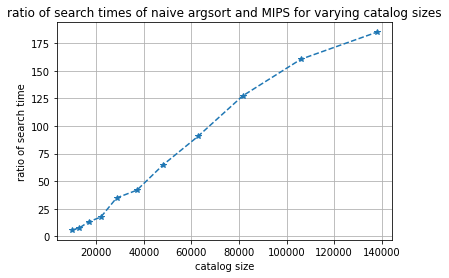

In [ ]:
search_times_ratios = np.array(argsort_times)/np.array(mips_times)
plt.plot(catalog_sizes, search_times_ratios, '*--')
plt.xlabel('catalog size')
plt.ylabel('ratio of search time')
plt.title('ratio of search times of naive argsort and MIPS for varying catalog sizes')
plt.grid()

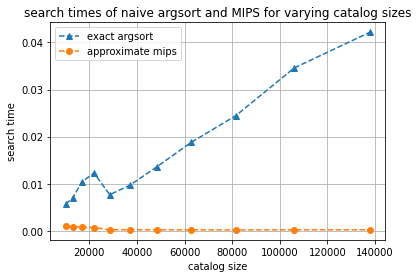

In [ ]:
search_times_ratios = np.array(argsort_times)/np.array(mips_times)
plt.plot(catalog_sizes, argsort_times, '^--', label='exact argsort')
plt.plot(catalog_sizes, mips_times, 'o--', label='approximate mips')
plt.xlabel('catalog size')
plt.ylabel('search time')
plt.title('search times of naive argsort and MIPS for varying catalog sizes')
plt.grid()
plt.legend()

In [ ]:
print('The ratios of search times are', search_times_ratios)

The ratios of search times are [  5.85233437   7.69916967  13.2598121   17.47429705  34.78746407
  41.84806846  65.04991844  90.52564607 127.27629255 160.47529995
 184.88331067]


In [ ]:
#Flat index: O(PlogK), where P is the number of products and K is the slate size
#flat_index = faiss.IndexFlat(d, faiss.METRIC_INNER_PRODUCT)
#flat_index.add(products_embeddings)

## Simulator Configuration

In [ ]:
class Oracle(FullModel):
    def __init__(self, nb_gs_categories, nb_bidding_features, bidding_mean, max_slate_size, **kwargs):
        super().__init__(
            bidding_init=np.random.randn(nb_bidding_features,1) * .1 + bidding_mean,
            add_position_bias_init=np.random.randn(1, max_slate_size) * 1 + 0,
            mult_position_bias_init=1-np.arange(max_slate_size).reshape([1, -1])/40,
            nb_gs_categories=nb_gs_categories,
            nb_bidding_features=nb_bidding_features,
            bidding_mean=bidding_mean,
            max_slate_size=max_slate_size,
            **kwargs
        )
        self.context_lookup = tf.Variable(
            tf.eye(nb_gs_categories),
            trainable=False
        )
        self.product_lookup = tf.Variable(
            tf.constant([
                [-1, -1, -1, -1],
                [  1,-.4, -.6,  .8],
                [-.2,  1, 0.2,   0],
                [-.6,-.6,   0,   1],
                [ -1, .8, -.2, -.8],
                [  0,  0,   1,  .6],
                [-.8,-.2,  .8,  .4],
                [ .8, -1,  -1,  -1]
            ], dtype=tf.float32),
            trainable=False
        )

In [ ]:
config = dict(max_slate_size=2,
              min_slate_size=2,
              nb_bidding_features=2,
              bidding_mean=8.,
              embedding_dim=6,
              nb_gs_categories=4,
              max_gs_categories=1,
              greedy_coef=1, # 1 means all actions are random
              catalog_size=7,
              nb_samples=15_000,
              ab_test_samples=20_000,
              num_epochs=160,
              batch_size=1024,
              learning_rate=0.005)

In [ ]:
config['criterion'] = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
config['optimizer'] = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])

In [ ]:
oracle = Oracle(**config)
logging_policy = RandomModel(**config)
simulator = Simulator(oracle_model=oracle, logging_model=logging_policy, **config)
logs = simulator(**config)

# getting the CTR of this generated log
ctr = np.mean([logs[i]['reward'] for i in range(len(logs))])
std = round(np.sqrt(ctr*(1-ctr)/config['nb_samples'])*100, 2)
ctr = round(ctr*100,2)
print(f"CTR Logs: {ctr} ± {std} %")

  0%|          | 0/15000 [00:00<?, ?it/s]

/content/drive/MyDrive/rewardoptimizingreco/Criteo/utils/simulator.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  single_item_propensity = tf.constant([logging_policy[action-1]], tf.float32)


CTR Logs: 4.7 ± 0.17 %


## Part2: Combining Reward and Rank vs. Reward Only

In [ ]:
# Training Reward and Rank (PRR), Rank only, and Reward Only

models = {'Oracle': oracle, 'Random': RandomModel(**config)}
PRETRAINED=False

if not PRETRAINED:
  for Model in [RewardModel, FullModel]:#
      config['optimizer'].learning_rate = config['learning_rate']
      model = Model(**config)
      print(f" Training {Model.__name__} ".center(40, "-"))
      model.train(logs, **config)
      models[Model.__name__] = model

else:
  x=1
  #TODO
  #tf.saved_model.save(models['RankingModel'], 'saved_models/ranking_model')
  #restored_model = tf.saved_model.load('saved_models/ranking_model')
  #original_model = models['RankingModel']  

In [ ]:
# compute \int P(c|a,Omega,X)P(X) dX - using all modelling approaches
def predictive_reward_oracle_model(models, logs, numX=600):

    inv_map_products = {0:'padding' , 1:'Run. Shoes', 2:'Phone', 3:'Boots', 4:'Mic', 5:'Carpet', 6:'Pillow', 7:'Tennis B.'}
    inv_map_context = {0: 'Sports', 1: 'Tech', 2: 'House', 3: 'Fashion'}

    vii = []
    vjj = []
    vscores = []
    vcontext = []
    vfull = []
    vrewardonly = []
    for ii in range(min(numX, len(logs))):
        sample = logs[ii]
        for cc in range(4): # for each context
            for ii in range(1,8): # for each pair of actions
                for jj in range(1,8):
                    if ii != jj:
                        scores = oracle(ind_products=tf.convert_to_tensor((np.array([[ii, jj]])),dtype=tf.int32),ind_segments=tf.convert_to_tensor((np.array([[cc]])),dtype=tf.int32), bidding_features=sample['bidding'])
                        vscores.append(1-np.exp(scores.numpy()[0,0])/np.sum(np.exp(scores.numpy())))

                        scores = models['FullModel'](ind_products=tf.convert_to_tensor((np.array([[ii, jj]])),dtype=tf.int32),ind_segments=tf.convert_to_tensor((np.array([[cc]])),dtype=tf.int32), bidding_features=sample['bidding'])
                        vfull.append(1-np.exp(scores.numpy()[0,0])/np.sum(np.exp(scores.numpy())))

                        scores = models['RewardModel'](ind_products=tf.convert_to_tensor((np.array([[ii, jj]])),dtype=tf.int32),ind_segments=tf.convert_to_tensor((np.array([[cc]])),dtype=tf.int32), bidding_features=sample['bidding'])
                        vrewardonly.append(1-np.exp(scores.numpy()[0,0])/np.sum(np.exp(scores.numpy())))

                        vii.append('a1='+inv_map_products[ii])
                        vjj.append('a2='+inv_map_products[jj])

                        vcontext.append(inv_map_context[cc])
    df_a1_a2 = pd.DataFrame({'context': vcontext, 'a1': vii, 'a2': vjj, 'ctr': vscores, 'ctr_full': vfull, 'ctr_rew': vrewardonly}).sort_values(['context','ctr'],ascending=False) 
    return df_a1_a2

df_a1_a2 = predictive_reward_oracle_model(models, logs,numX=600)

In [ ]:
%%R -i df_a1_a2 -w 8 -h 5 --units in -r 1000
library(data.table)
library(ggplot2)

# compute the orcale and model based estimates
df_a1_a2<-data.table(df_a1_a2)
g<-df_a1_a2[,list(ctr=mean(ctr),ctr.err=sd(ctr)/sqrt(.N),ctr_full=mean(ctr_full),ctr_rew=mean(ctr_rew)),list(context,a1,a2)]

# nice plot!
gg<-melt(g,c('context','a1','a2'),c('ctr','ctr_full','ctr_rew'))

setnames(gg,c('context','a1','a2','Estimate','value'))
gg[Estimate=='ctr',Estimate:='Oracle']
gg[Estimate=='ctr_full',Estimate:='Full Model']
gg[Estimate=='ctr_rew',Estimate:='Reward Model']


ggplot(gg) + geom_point(aes(x=a2,y=value,colour=Estimate),size=0.6, position = position_dodge(width = 0.9)) + facet_grid(context ~ a1) + theme_bw() + theme(text = element_text(size = 8))   + theme(axis.text.x = element_text(angle = 90)) + ylab('CTR') + xlab('')  #+ coord_cartesian(xlim=c(0.15,0.4),ylim=c(0.15,0.4)) 


## Part3: Combining Reward and Rank vs. IPS

In [ ]:
# Training IPS and IIPS
for Model in [SlateIPS, IndependentIPS]:
    # Without TopK
    config['optimizer'].learning_rate = config['learning_rate']
    model = Model(**config)
    print(f" Training {Model.__name__} ".center(40, "-"))
    model.train(logs, **config)
    models[Model.__name__] = model

    # With TopK
    #config['optimizer'].learning_rate = config['learning_rate']
    #model = Model(**config)
    #print(f" Training {Model.__name__} with TopK".center(40, "-"))
    #model.train(logs, topk=3, **config)
    #models['TopK'+Model.__name__] = model

In [ ]:
# do IPS
def two_action_ips(logs):
    inv_map_products = {0:'padding' , 1:'Run. Shoes', 2:'Phone', 3:'Boots', 4:'Mic', 5:'Carpet', 6:'Pillow', 7:'Tennis B.'}
    inv_map_context = {0: 'Sports', 1: 'Tech', 2: 'House', 3: 'Fashion'}


    ll = []

    for ii in range(len(logs)):
        slate_size = logs[ii]['slate_size'].numpy()[0,0]
        if slate_size == 2:
            a1 = logs[ii]['products'].numpy()[0,0]
            a2 = logs[ii]['products'].numpy()[0,1]

            click = 1-logs[ii]['labels'].numpy()[0,0]

            ps = logs[ii]['slate_propensity'].numpy()[0]

            context = logs[ii]['gs'].numpy()[0,0]
            ll.append(pd.DataFrame({'context': [inv_map_context[context]], 'a1': 'a1='+inv_map_products[a1], 'a2': 'a2='+inv_map_products[a2], 'ps': ps, 'click': click}))

    df_ps = pd.concat(ll)
    return df_ps

df_ps = two_action_ips(logs)

In [ ]:
%%R -i df_a1_a2 -i df_ps -w 8 -h 5 --units in -r 1000
library(data.table)
library(ggplot2)

# compute the orcale and model based estimates
df_a1_a2<-data.table(df_a1_a2)
g<-df_a1_a2[,list(ctr=mean(ctr),ctr.err=sd(ctr)/sqrt(.N),ctr_full=mean(ctr_full)),list(context,a1,a2)]


# compute the slate IPS based estimate
df_ps<-data.table(df_ps)
slateips<-merge(df_ps[,list(click=sum(click),ps=mean(ps)),list(a1, a2,context)],df_ps[,.N,context])
slateips<-slateips[,ctr_ips:=click/(ps*N)][,list(context,a1,a2,ctr_ips)]
g <-merge(g,slateips,by=c('context','a1','a2'))


# nice plot!
gg<-melt(g,c('context','a1','a2'),c('ctr','ctr_full','ctr_ips'))

setnames(gg,c('context','a1','a2','Estimate','value'))
gg[Estimate=='ctr',Estimate:='True']
gg[Estimate=='ctr_ips',Estimate:='IPS']
gg[Estimate=='ctr_full',Estimate:='Full Model']


ggplot(gg) + geom_point(aes(x=a2,y=value,colour=Estimate),size=0.6, position = position_dodge(width = 0.9)) + facet_grid(context ~ a1) + theme_bw() + theme(text = element_text(size = 8))   + theme(axis.text.x = element_text(angle = 90)) + ylab('CTR') + xlab('')  #+ coord_cartesian(xlim=c(0.15,0.4),ylim=c(0.15,0.4)) 

In [ ]:
%%R -i df_a1_a2 -w 6 -h 2 --units in -r 800
library(data.table)
library(ggplot2)

df_a1_a2<-data.table(df_a1_a2)
g<-df_a1_a2[,list(ctr=mean(ctr),ctr.err=sd(ctr)/sqrt(.N),ctr_full=mean(ctr_full),ctr_rew=mean(ctr_rew)),list(context,a1,a2)]


# compute the slate IPS based estimate
df_ps<-data.table(df_ps)
slateips<-merge(df_ps[,list(click=sum(click),ps=mean(ps)),list(a1, a2,context)],df_ps[,.N,context])
slateips<-slateips[,ctr_ips:=click/(ps*N)][,list(context,a1,a2,ctr_ips)]
g <-merge(g,slateips,by=c('context','a1','a2'))


gg<-melt(g,c('context','a1','a2'),c('ctr','ctr_full','ctr_rew', 'ctr_ips'))


setnames(gg,c('context','a1','a2','Estimate','value'))
gg[Estimate=='ctr',Estimate:='True']
gg[Estimate=='ctr_ips',Estimate:='IPS']
gg[Estimate=='ctr_full',Estimate:='Full Model']
gg[Estimate=='ctr_rew',Estimate:='Reward Model']

gg_gg <- merge(gg[Estimate=='True'],gg[Estimate!='True'],by=c('context','a1','a2'))

setnames(gg_gg, c('context', 'a1', 'a2', 'Estimate.x', 'value.x', 'Estimate', 'value.y'))

ggplot(gg_gg) + geom_point(aes(x=value.x,y=value.y,colour=Estimate)) + facet_grid(. ~ Estimate) + theme_bw()  + theme(axis.text.x = element_text(angle = 90)) + xlab('True CTR') + ylab('Estimated CTR')  + theme(text = element_text(size = 6)) +  coord_cartesian(xlim=c(0.05,0.15),ylim=c(0.05,0.15)) 



# END